[View in Colaboratory](https://colab.research.google.com/github/kmanicka/CarND-Behavioral-Cloning-P3/blob/master/Model.ipynb)

# Udacity Car ND : Behavioral Cloning Project

This notebook is used to build and train the model used for driving the car autonomously 


## Versions 


#### Versions 6
- Use Data Generator 


#### Versions 5
- Merged build and train cells. 
- Merged Load and prepare data

#### Versions 4
- Normalization and croping in the Keras Layer
- Dropout in 3 layers 0.25
- Files changed the model and the drive.py 

#### Versions 3
- Reduced the image height to concentrate on roads only.  
- the training and prediction image has changed. 

Result: The car drived well till it got distracted at road with brown road curb.  

#### Versions 2
A basic Lenet Model updated for linear regression. 


##  Workspace setup

* clean the workspace 
* download and unzip files
* list and assert files

```
date > log.txt
rm -rf *.zip  >> log.txt 2>&1
wget https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip >> log.txt 2>&1
unzip data.zip >> log.txt 2>&1
date >> log.txt 2>&1

ls
ls data
ls data/IMG | wc
```

In [94]:
from skimage.io import imread
from  keras.utils import  Sequence
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

CENTER     = 1
LEFT       = 2
RIGHT      = 3
CENTER_REV = 4  #horizontally reversed
LEFT_REV   = 5  #horizontally reversed
RIGHT_REV  = 6  #horizontally reversed


class BehavioralDataGenerator(Sequence):
    
    #util function
    def __get_slice(self,driving_log,image_type,column_name):
        driving_log["type"] = image_type
        images = driving_log[["type", column_name,"steering"]]
        images.columns = ["type","image","steering"]
        return images
    
    def __init__(self,base_dir,batch_size,height,width,channels,shuffle=True) :
        
        self.base_dir = base_dir
        self.batch_size = batch_size
        self.height = height
        self.width = width
        self.channels = channels
        self.shuffle = shuffle
        
        driving_log = pd.read_csv(self.base_dir + 'driving_log.csv', sep=',')
                
        self.data = pd.concat([
            self.__get_slice(driving_log, CENTER,    'center'),
            self.__get_slice(driving_log, LEFT,      'left'  ),
            self.__get_slice(driving_log, RIGHT,     'right' ),
            self.__get_slice(driving_log, CENTER_REV,'center'),
            self.__get_slice(driving_log, LEFT_REV,  'left'  ),
            self.__get_slice(driving_log, RIGHT_REV, 'right' )
            ])
        
        self.indexes = np.arange(len(self.data))
        
        
    
    def __len__(self):
        return int(np.ceil(len(self.data) / float(self.batch_size)))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, idx):
        batch = self.data[idx * self.batch_size : (idx + 1) * self.batch_size]
        
        X = np.empty((self.batch_size, self.height, self.width, self.channels))
        y = np.empty((self.batch_size,1), dtype=float)
        
        for i in range(len(batch)):            
            image_type = batch.values[i,0]
            image = imread(self.base_dir + batch.values[i,1].strip()) 
            image = image * 255
            steering = batch.values[i,2]
             
            
            #adjust left
            if image_type == LEFT or image_type == LEFT_REV :
                steering = steering + 0.2

            #adjust right
            if image_type == RIGHT or image_type == RIGHT_REV :
                steering = steering - 0.2

            #adjust horizantal reverse
            if image_type == CENTER_REV or image_type == LEFT_REV or image_type == RIGHT_REV :
                steering = steering * -1
                image = np.flip(image,axis=1)
                
            X[i] = image
            y[i] = steering
            
        return X, y


In [98]:
# Tests for the BehavioralDataGenerator 


generator = BehavioralDataGenerator('data/',1,160,320,3,shuffle=True)
generator.on_epoch_end()

fig=plt.figure(figsize=(15, 15))
rows,columns = 2,3
i=0

#center image
row = 270
X_batch, y_batch =generator.__getitem__(row)
print(y_batch[0])
i=i+1
fig.add_subplot(rows, columns, i)
plt.imshow(X_batch[0])

#left image
row=row+8036
X_batch, y_batch =generator.__getitem__(row)
print(y_batch[0])
i=i+1
fig.add_subplot(rows, columns, i)
plt.imshow(X_batch[0])

#right image
row=row+8036
X_batch, y_batch =generator.__getitem__(row)
print(y_batch[0])
i=i+1
fig.add_subplot(rows, columns, i)
plt.imshow(X_batch[0])

#reverse center image
row=row+8036
X_batch, y_batch =generator.__getitem__(row)
print(y_batch[0])
i=i+1
fig.add_subplot(rows, columns, i)
plt.imshow(X_batch[0])

#reverse left image
row=row+8036
X_batch, y_batch =generator.__getitem__(row)
print(y_batch[0])
i=i+1
fig.add_subplot(rows, columns, i)
plt.imshow(X_batch[0])

#reverse right image
row=row+8036
X_batch, y_batch =generator.__getitem__(row)
print(y_batch[0])
i=i+1
fig.add_subplot(rows, columns, i)
plt.imshow(X_batch[0])


KeyError: 1803

# Build and Train Model



Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 86, 316, 4)        304       
_________________________________________________________________
activation_1 (Activation)    (None, 86, 316, 4)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 158, 4)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 39, 154, 8)        808       
_________________________________________________________________
activation_2 (Activation)    (None, 39, 154, 8)        0         
__________

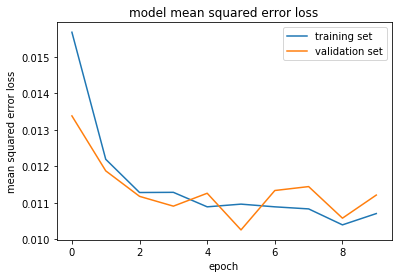

In [2]:
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, Activation
from keras.layers import Conv2D, MaxPooling2D, Cropping2D,Lambda 
from keras.callbacks import ModelCheckpoint

def get_model(input_shape) :

    model = Sequential()
    
    #Layer Normilization
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=input_shape))
    
    #Layer Cropping
    model.add(Cropping2D(cropping=((50,20), (0,0))))

    #Layer Conv 1 
    model.add(Conv2D(4, (5, 5), padding="valid"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    #Layer Conv 2
    model.add(Conv2D(8, (5, 5), padding="valid"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))


    #Layer Conv 3
    model.add(Conv2D(16, (5, 5), padding="valid"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    #Layer Dense 1
    model.add(Dense(32))
    model.add(Activation("relu"))
    model.add(Dropout(0.25))

    #Layer Dense 2
    model.add(Dense(8))
    model.add(Activation("relu"))
    model.add(Dropout(0.25))

    #Layer Dense 4
    model.add(Dense(1)) 

    model.compile(loss='mse', optimizer='adam')


    return model

model = get_model((X_train.shape[1],X_train.shape[2],X_train.shape[3]))
model.summary()

weights_filepath="weights-5.hdf5"

checkpoint = ModelCheckpoint(weights_filepath, verbose=1)

history_object = model.fit(X_train, Y_train, 
                            validation_split=0.2,
                            shuffle=True, 
                            epochs=10, 
                            batch_size=32,
                            callbacks=[checkpoint])


print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

